In [11]:
#!/usr/bin/python3
import os
import numpy as np
import string
import pandas as pd
from pandas import DataFrame
import random
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from random import choice

In [12]:
#This routine returns all the paths from the node v
def DFS(G,v,seen=None,path=None):
    if seen is None: seen = []
    if path is None: path = [v]

    seen.append(v)

    paths = []
    for t in G[v]:
        if t not in seen:
            t_path = path + [t]
            paths.append(tuple(t_path))
            paths.extend(DFS(G, t, seen[:], t_path))
    return paths

#Given a set of paths this routine returns the maximum length chain
def give_a_max_path(all_paths):
        
    
    max_len   = max(len(p) for p in all_paths)
    
    max_paths = [p for p in all_paths if len(p) == max_len]
        
    num_max_paths = len(max_paths)
        
    chosen_path = max_paths[np.random.randint(num_max_paths)]
    
    return chosen_path, max_len

def union(list1,list2):
    return list(set(list1) | set(list2))



In [32]:
# Defining the tree dictionary for each node
# Each block tree is a dictionary
# Each node is in nodes[] list

num_nodes = 10000

max_blocks = 100

#Chyeck list of lists


delay_vector= np.arange(0,5.25,0.25)
#delay_vector=[5]

num_delays=len(delay_vector)

num_trials = 4

MCL={}

#max_len_tracker = np.zeros((num_delays, max_blocks+1, num_trials))

D_tilde_factor = 0.1
threshold_coefficient=0.1

temporary_guess = x0_array
print(temporary_guess)

poll_L_array = [10]
#poll_L_array=[10]
delay_dict = {}
for i in poll_L_array:
    delay_dict[i] = [0.5,1.5]
    MCL[i] = {}
    for j in delay_dict[i]:
        MCL[i][j] = []

print(delay_dict)
print(MCL)

[0.6509433962264151, 0.9633579865203217, 1.2817201391074913, 1.450210771810214, 1.4912710657963957, 1.513917299224777, 1.5296976949630299, 1.472980385399615, 1.2495139657930356]
{10: [0.5, 1.5]}
{10: {0.5: [], 1.5: []}}


In [33]:
for poll_L in poll_L_array:
    print(poll_L)
    delay_vector = delay_dict[poll_L]
    num_delays=len(delay_vector)
    for d in range(num_delays):

        Delay = delay_vector[d]

        data={} 

        D_tilde = D_tilde_factor*Delay

        print("Starting with delay:", Delay)

        for trial in range(num_trials):

            nodes = num_nodes*[0]

            #Tree variables
            num_in_strings = [str(i) for i in range(max_blocks+1)]



            for i in range(num_nodes):
                nodes[i] = {i:[] for i in num_in_strings[:-1]}

            # nodes[i] is a dictionary of block tree for node i which contains children of the blocks 0,1,....,T-1    

            god_node_children = {i:[] for i in num_in_strings}    
            god_node_parents = {i:"" for i in num_in_strings[:-1]}

            rechability_matrix= np.zeros((num_nodes,max_blocks+1))
            rechability_matrix[:,0]=1

            delay_variables = np.random.exponential(Delay,(num_nodes,max_blocks+1))

            poll_delay = np.random.exponential(D_tilde,(max_blocks+1,poll_L-1))
            poll_delay = poll_delay + 0.1*D_tilde*(poll_L-1)
            threshold_timer = threshold_coefficient*Delay
            actual_poll_delay = np.full(max_blocks+1,threshold_timer)
            maximum_poll_delay = np.amax(poll_delay,1)
            actual_poll_delay = np.minimum(maximum_poll_delay,actual_poll_delay)
            
            #print(D_tilde)
            #print(np.mean(poll_delay))
            #poll_delay = np.zeros((max_blocks+1))
            #poll_delay = poll_delay+D_tilde    

            #Block arrival process
            for t in range(1, max_blocks+1):

                chosen_node = np.random.randint(num_nodes)

                delay_variables[chosen_node,t] = 0  # Removing GOD model\n"

                # Update block trees for all nodes "n"

                if t==1:
                    god_node_children["0"].append(str(t))

                    god_node_parents[str(t)] = str(0)


                else:


                    #Updating the block trees of all the nodes corresponding to the blocks 1,...t-1

                    for tau in range(1,t):

                        for k in range(num_nodes):

                            if delay_variables[k,tau] < t-tau-actual_poll_delay[tau]:

                                rechability_matrix[k,tau]=1

                                if str(tau) not in nodes[k][god_node_parents[str(tau)]]:
                                    nodes[k][god_node_parents[str(tau)]].append(str(tau))

                    #Find the longest path for  chosen node n starting from the genesis block 0,1,,


                    #If we poll we merge the dictionaries a.k.a local block trees and then chose the longest path

                    #graph = nodes[chosen_node]

                    #Updating the chosen node blocktree due to polling delay in proposal

                    for tau in range(1,t):
                        if delay_variables[chosen_node,tau] < t+actual_poll_delay[t]-tau-actual_poll_delay[tau]:

                            rechability_matrix[chosen_node,tau]=1

                            if str(tau) not in nodes[chosen_node][god_node_parents[str(tau)]]:
                                nodes[chosen_node][god_node_parents[str(tau)]].append(str(tau))

                chosen_graph = nodes[chosen_node]
                
                polled_node=chosen_node
                
                polling_list=list(range(num_nodes))
                
                polling_list.remove(polled_node)
                
                for i in range(poll_L-1):
                    
                    if poll_delay[t][i] <= actual_poll_delay[t]:
                        
                        polled_node = choice(polling_list)

                        polled_graph = nodes[polled_node]

                        chosen_graph = {x:union(chosen_graph[x],polled_graph[x]) for x in chosen_graph}

                        polling_list.remove(polled_node)
                             
                
                all_paths = DFS(chosen_graph, "0")

                if len(all_paths)==0:

                    chosen_leaf="0"

                else:

                    chosen_path, max_len = give_a_max_path(all_paths)

                    chosen_leaf=chosen_path[-1]


                #Attach this node in the Global tree

                god_node_children[chosen_leaf].append(str(t))

                god_node_parents[str(t)] = chosen_leaf


                _, temp_length = give_a_max_path(DFS(god_node_children,"0"))


                temp_length = temp_length-1

                if t%25==0:
                    print(temp_length)
                
                if t%100 == 0:

                    print("Trial {0}: Block {1} arrived : Growth rate of the main chain is {2}".format(trial, t, temp_length))
                    MCL[poll_L][Delay].append(temp_length)



            #data["Trial%d"%(trial)]= max_len_tracker[d,:,trial]
            #df = pd.DataFrame(data=data)            
            #df.to_csv('poll_delay_conservative/'+'updated_delay2_poll4_n%d_T%d_D%.2f.csv'%(num_nodes,max_blocks,Delay))



10
Starting with delay: 0.5
24
47
70
95
Trial 0: Block 100 arrived : Growth rate of the main chain is 95
24
47
70
94
Trial 1: Block 100 arrived : Growth rate of the main chain is 94
22
44
69
93
Trial 2: Block 100 arrived : Growth rate of the main chain is 93
23
47
71
95
Trial 3: Block 100 arrived : Growth rate of the main chain is 95
Starting with delay: 1.5
17
33
49
68
Trial 0: Block 100 arrived : Growth rate of the main chain is 68
16
31
48
67
Trial 1: Block 100 arrived : Growth rate of the main chain is 67
17
34
51
71
Trial 2: Block 100 arrived : Growth rate of the main chain is 71
18
36
55
71
Trial 3: Block 100 arrived : Growth rate of the main chain is 71


In [34]:
print(MCL)

{10: {0.5: [95, 94, 93, 95], 1.5: [68, 67, 71, 71]}}


In [37]:
EMCL = {}
VMCL = {}
for i in range(10,11):
    EMCL[i] = {}
    VMCL[i] = {}
    for j in [1-0.5,1+0.5]:
        EMCL[i][j] = np.mean(np.array([MCL[i][j]]))
        VMCL[i][j] = np.var(np.array([MCL[i][j]]))/4
print(VMCL[10])

{0.5: 0.171875, 1.5: 0.796875}


In [38]:
def calculate_x0(y1,y2,y0,x1,x2):
    return(x1+ (y0-y1)*(x2-x1)/(y2-y1))

def calculate_var_x0(y1,y2,y0,x1,x2,vary1,vary2):
    temp_term1 = ((x2-x1)**2)*((y0-y1)**2)/((y2-y1)**2)
    
    temp_term2 = vary1/((y0-y1)**2) + (vary2+vary1)/((y2-y1)**2)
    
    return temp_term1*temp_term2

In [26]:
EMCL[1] = {}
VMCL[1] = {}
EMCL[1][0.5] = 88.0
EMCL[1][0.75] = 74.75
VMCL[1][0.5] = 1.5/4
VMCL[1][0.75] = 8.6875/4

In [39]:
x0_array = []
std_x0_array = []
for i in range(10,11):
    [x1,x2]=list(EMCL[i].keys())
    [y1,y2]=list(EMCL[i].values())
    [vary1,vary2] = list(VMCL[i].values())
    y0 = 80
    x0 = calculate_x0(y1,y2,y0,x1,x2)
    var_x0=calculate_var_x0(y1,y2,y0,x1,x2,vary1,vary2)
    x0_array.append(x0)
    std_x0_array.append(np.sqrt(var_x0))
                      
    
print(x0_array)
print(std_x0_array)

[1.0699999999999998]
[0.02790331521522129]


In [30]:
x0_finalized = x0_array
std_x0_finalized = std_x0_array
#x0_finalized.pop()
#std_x0_finalized.pop()

In [40]:
x0_finalized.append(x0_array[0])
std_x0_finalized.append(std_x0_array[0])

In [41]:
print(x0_finalized)
print(std_x0_finalized)

[0.6509433962264151, 0.9633579865203217, 1.2817201391074913, 1.450210771810214, 1.4912710657963957, 1.513917299224777, 1.5296976949630299, 1.472980385399615, 1.2495139657930356, 1.0699999999999998]
[0.02154122349816967, 0.030240614108434295, 0.10280907602304622, 0.08922305567021913, 0.056184277345366164, 0.053039630553595465, 0.038945273195620515, 0.08115618814800397, 0.06643974300973336, 0.02790331521522129]


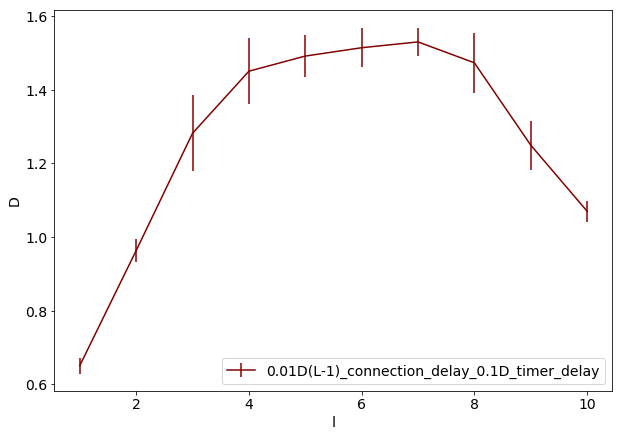

In [43]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,7))
plt.errorbar(range(1,11),x0_finalized,std_x0_finalized,color=(0.5,0,0))
plt.xlabel('l')
plt.ylabel('D')
plt.legend(['0.01D(L-1)_connection_delay_0.1D_timer_delay'])
#plt.title('Lower_bound_tightness')
#plt.savefig('lower_bound1.fig')
plt.show()

In [44]:
np.save('DvsL_dict/0.01D_connect_0.1Dtimer_mean.npy',np.array(x0_finalized))
np.save('DvsL_dict/0.01D_connect_0.1Dtimer_std.npy',np.array(std_x0_finalized))